In [1]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.2 MB/s 


In [2]:
# Standard libraries imports
import requests
import numpy as np
import pandas as pd
from scipy import stats
import pyarabic.araby as araby

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# list of all Arabic characters
chars = list('اٱبتةثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئىی')
print('Number of Arabic Characters:', len(chars))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(chars))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(chars))

char_to_index['p'] = 0 # pad
char_to_index['s'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = 'p' # pad
index_to_char[1] = 's' # separator
index_to_char[2] = '_' # mask

# additional char_to_index and index_to_char extracted manually as shown in next 
# cells. They were extracted and then saved into a CSV file
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1lQFU7XFy82-1dE5kPK7yDLpJ6tleycCC')
chars_2 = df['char'].values.tolist()
indexes_2 = df['value'].values.tolist()
del df

# additional character to index dictionary
char_to_index_2 = dict(zip(chars_2, indexes_2))
# additional index to character dictionary
index_to_char_2 = dict(zip(indexes_2, chars_2))

Number of Arabic Characters: 38


In [5]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [6]:
# read the competition test dataset
test_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.gold', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
test_df = test_df.iloc[:, :2]
# rename the columns
test_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in test_df.columns:
  test_df[col] = test_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
test_df.head(10)

,singular,plural
0,طربيد,طوربيدات
1,مولود,مواليد
2,ضروري,ضروريات
3,معني,معنيين
4,جدار,جدران
5,كوليس,كواليس
6,حديقة,حدائق
7,حياة,حيوات
8,دمية,دمى
9,تعاقد,تعاقدات


# Helper Functions

In [7]:
def indexes_to_word(example):
  '''
  Args: an array of indexes
  Returns: a list of characters
  '''
  example = example.tolist()
  list_of_chars = [index_to_char[idx] for idx in example]
  return list_of_chars

In [8]:
def final_prediction_as_chars(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of characters of the predictions from the start to the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  # flip the predictions (Arabic)
  flipped_example = np.flip(example)
  # find the position of the first separator index, which is 1
  first_separator_index = np.where(flipped_example == 1)[0][0]
  # limit the returned sequence to the first separator
  predicted_flipped_example = flipped_example[:first_separator_index]
  # convert the array into a list
  example = np.int32(predicted_flipped_example).tolist()
  # convert indexes into characters
  pred_chars = [index_to_char[i] for i in example]
  # if gold is required, return it
  if return_gold:
    gold = list(test_df.iloc[index, 1])
    return pred_chars, gold
  return pred_chars

In [9]:
def final_prediction_as_indexes(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of indexes of the predictions from the start to the index of the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  # flip the predictions (Arabic)
  flipped_example = np.flip(example)
  # find the position of the first separator index, which is 1
  first_separator_index = np.where(flipped_example == 1)[0][0]
  # limit the returned sequence to the first separator
  predicted_flipped_example = flipped_example[:first_separator_index]
  # convert the array into a list
  pred_indexes = np.int32(predicted_flipped_example).tolist()
  # if gold is required, return it
  if return_gold:
    gold = [char_to_index[char] for char in list(test_df.iloc[index, 1])]
    return pred_indexes, gold
  return pred_indexes

In [10]:
def arabic_leven_dis(gold, pred, return_matrix=False):
  '''
  Levenshtein distance
  Args:
    gold: list of indexes of the gold characters
    pred: list of indexes of the predicted characters
  Returns:
    Levenshtein distance
  '''

  # construct a matrix of the correct size
  sol = np.zeros((len(pred), len(gold)))

  # first row and column
  sol[0, :] = np.flip([i for i in range(len(gold))])
  sol[:, -1] = [i for i in range(len(pred))]

  # fill in the rest
  # through every column
  for c in reversed(range(len(gold) - 1)):
    # through every row
    for r in range(1, len(pred)):

      # in case not the same corresponding letters, take the minimum value of the above right corner three values (Arabic) + 1 
      if gold[c] != pred[-(r+1)]:
        sol[r, c] = min(sol[r-1, c+1], sol[r-1, c], sol[r, c+1]) + 1
      # in case the corresponding letters are the same, take the upper diagonal value
      else:
        sol[r, c] = sol[r-1, c+1]

  # if the full matrix is required
  if return_matrix: 
    return sol
  # if only the minimum number of edits is required
  return sol[-1, 0]

In [11]:
# load the predictions
url = 'https://drive.google.com/uc?export=download&id=1G6PUu5q23radFEZNxCtJZ1XVG18GExK5'
r = requests.get(url, allow_redirects=True)
open('validation_set_prediction_2.npy', 'wb').write(r.content)
# read the predictions NumPy array
with open('/content/validation_set_prediction_2.npy', 'rb') as f:
  preds = np.load(f)

In [12]:
# construct a distances list
distances = []
# iterate over each plural example in the validation set
for i in range(len(test_df)):
  # extract the final predicted indexes alongside with the ground truth ones
  pred, gold = final_prediction_as_indexes(i, True)
  gold = gold + [-1] # add -1 for the '#' in the Levenshtein distance
  pred = pred + [-1] # add -1 for the '#' in the Levenshtein distance
  # calculate the minimum edits required
  dist = arabic_leven_dis(gold, pred)
  # append the distance to the distances list
  distances.append(dist)

# convert the distances list into a NumPy array
distances = np.array(distances)

In [13]:
# print the statistics of the distances array
statistics = stats.describe(distances)
statistics

DescribeResult(nobs=600, minmax=(0.0, 7.0), mean=1.625, variance=1.8808430717863105, skewness=0.3576180080411362, kurtosis=-0.5226886976587402)

In [14]:
# display additional statistics using Pandas methods
pd.DataFrame({'dist': distances}).describe()

,dist
count,600.000000
mean,1.625000
std,1.371438
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,7.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


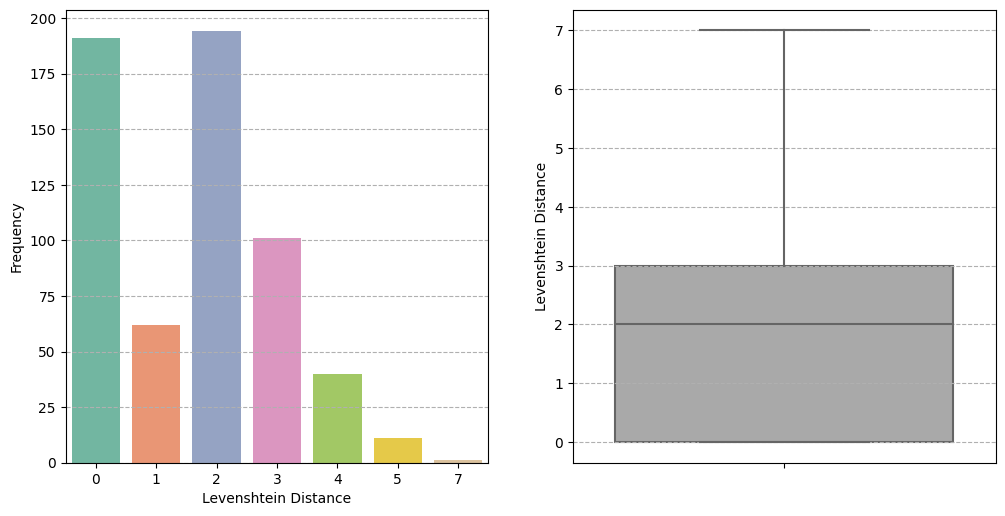

In [15]:
plt.figure(figsize=(12, 6), dpi=100)
plt.subplot(1, 2, 1)
# plot a figure showing the frequencies of each distance value
sns.countplot(np.int32(distances), palette="Set2")
# plt.box(False)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Frequency')
plt.title('')
plt.grid(linestyle='dashed', alpha=1, axis='y')
plt.subplot(1, 2, 2)
# plot a box plot that shows the distribution of distances
sns.boxplot(y=distances, color='darkgrey')
plt.ylabel('Levenshtein Distance')
# plt.box(False)
plt.grid(linestyle='dashed', alpha=1, axis='y')
plt.savefig('test_frequency.jpg', dpi=100, bbox_inches='tight')
plt.show()

In [16]:
# the whole dataset
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(test_df.iloc[:, -1].values.tolist()):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 256
Number of masculine examples: 64
Number of takseer examples: 280


# Intensive Study

In [17]:
# print(count of each Levenshtein distance)
dists = np.unique(np.int32(distances), return_counts=True)[0]
couts = np.unique(np.int32(distances), return_counts=True)[1]
display(pd.DataFrame({'Distance': dists, 'Counts': couts}))

,Distance,Counts
0,0,191
1,1,62
2,2,194
3,3,101
4,4,40
5,5,11
6,7,1


In [18]:
# group by each distance value
zero_distance_indexes = np.where(distances==0)[0]
one_distance_indexes = np.where(distances==1)[0]
two_distance_indexes = np.where(distances==2)[0]
three_distance_indexes = np.where(distances==3)[0]
four_distance_indexes = np.where(distances==4)[0]
five_distance_indexes = np.where(distances==5)[0]
six_distance_indexes = np.where(distances==6)[0] # empty list (no examples lie in this range)
seven_distance_indexes = np.where(distances==7)[0]

## Zero Levenshtein Distance (Perfect Match) 

In [19]:
# extract a list of the plural forms
zero_distance_plural = test_df.iloc[zero_distance_indexes, -1].values.tolist()

In [20]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(zero_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 156
Number of masculine examples: 5
Number of takseer examples: 30


In [21]:
# retrieving takseer examples
takseer_examples = [zero_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [22]:
# retrieving feminine examples
feminine_examples = [zero_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

تقنيات is in training set
تشكيلات is in training set
ضمانات is in training set
مجتمعات is in training set
مساعدات is in training set
مقررات is in training set
**************************************************
6 out of 156 words is/are in the training set


In [23]:
# retrieving masculine examples
masculine_examples = [zero_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## One Levenshtein Distance

In [24]:
# extract a list of the plural forms
one_distance_plural = test_df.iloc[one_distance_indexes, -1].values.tolist()

In [25]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(one_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 25
Number of masculine examples: 1
Number of takseer examples: 36


In [26]:
# retrieving takseer examples
takseer_examples = [one_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

منشآت is in training set
**************************************************
1 out of 36 words is/are in the training set


In [27]:
# retrieving feminine examples
feminine_examples = [one_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [28]:
# retrieving masculine examples
masculine_examples = [one_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Two Levenshtein Distance

In [29]:
# extract a list of the plural forms
two_distance_plural = test_df.iloc[two_distance_indexes, -1].values.tolist()

In [30]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(two_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 54
Number of masculine examples: 30
Number of takseer examples: 110


In [31]:
# retrieving takseer examples
takseer_examples = [two_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

عموم is in training set
**************************************************
1 out of 110 words is/are in the training set


In [32]:
# retrieving feminine examples
feminine_examples = [two_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

إستراتيجيات is in training set
لوحات is in training set
تقديمات is in training set
**************************************************
3 out of 54 words is/are in the training set


In [33]:
# retrieving masculine examples
masculine_examples = [two_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

متهمين is in training set
**************************************************
1 out of 30 words is/are in the training set


## Three Levenshtein Distance

In [34]:
# extract a list of the plural forms
three_distance_plural = test_df.iloc[three_distance_indexes, -1].values.tolist()

In [35]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(three_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 13
Number of masculine examples: 20
Number of takseer examples: 68


In [36]:
# retrieving takseer examples
takseer_examples = [three_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

أعلام is in training set
**************************************************
1 out of 68 words is/are in the training set


In [37]:
# retrieving feminine examples
feminine_examples = [three_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [38]:
# retrieving masculine examples
masculine_examples = [three_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Four Levenshtein Distance

In [39]:
# extract a list of the plural forms
four_distance_plural = test_df.iloc[four_distance_indexes, -1].values.tolist()

In [40]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(four_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 7
Number of masculine examples: 6
Number of takseer examples: 27


In [41]:
# retrieving takseer examples
takseer_examples = [four_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [42]:
# retrieving feminine examples
feminine_examples = [four_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [43]:
# retrieving masculine examples
masculine_examples = [four_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Five Levenshtein Distance

In [44]:
# extract a list of the plural forms
five_distance_plural = test_df.iloc[five_distance_indexes, -1].values.tolist()

In [45]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(five_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 1
Number of masculine examples: 1
Number of takseer examples: 9


In [46]:
# retrieving takseer examples
takseer_examples = [five_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [47]:
# retrieving feminine examples
feminine_examples = [five_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [48]:
# retrieving masculine examples
masculine_examples = [five_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Seven Levenshtein Distance

In [49]:
# extract a list of the plural forms
seven_distance_plural = test_df.iloc[seven_distance_indexes, -1].values.tolist()

In [50]:
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(seven_distance_plural):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 0
Number of masculine examples: 1
Number of takseer examples: 0


In [51]:
# retrieving takseer examples
takseer_examples = [seven_distance_plural[i] for i in takseer_indexes]

# ensure all takseer examples are not in the training set
counts = 0
for word in takseer_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {takseer_counts} words is/are in the training set")

No word in the validation set is in the training set


In [52]:
# retrieving feminine examples
feminine_examples = [seven_distance_plural[i] for i in feminine_indexes]

# ensure all feminine examples are not in the training set
counts = 0
for word in feminine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {feminine_counts} words is/are in the training set")

No word in the validation set is in the training set


In [53]:
# retrieving masculine examples
masculine_examples = [seven_distance_plural[i] for i in masculine_indexes]

# ensure all masculine examples are not in the training set
counts = 0
for word in masculine_examples:
  if (word in train_df.iloc[:, -1].values.tolist()):
    print(f"{word} is in training set")
    counts += 1
if counts == 0:
  print("No word in the validation set is in the training set")
else:
  print('*'*50)
  print(f"{counts} out of {masculine_counts} words is/are in the training set")

No word in the validation set is in the training set


## Visualization

In [54]:
# create a dictionary that contains the examples of each distance value
dict_ = dict()
dict_['zero_distance_plural'] = test_df.iloc[zero_distance_indexes, -1].values.tolist()
dict_['one_distance_plural'] = test_df.iloc[one_distance_indexes, -1].values.tolist()
dict_['two_distance_plural'] = test_df.iloc[two_distance_indexes, -1].values.tolist()
dict_['three_distance_plural'] = test_df.iloc[three_distance_indexes, -1].values.tolist()
dict_['four_distance_plural'] = test_df.iloc[four_distance_indexes, -1].values.tolist()
dict_['five_distance_plural'] = test_df.iloc[five_distance_indexes, -1].values.tolist()
dict_['seven_distance_plural'] = test_df.iloc[seven_distance_indexes, -1].values.tolist()

# create a list to hold the counts across distances
feminine_counts_list = []
masculine_counts_list = []
takseer_counts_list = []

for key in [*dict_]:
  # count the masculine, feminine, and takseer forms based on the word endings
  feminine_counts = 0
  masculine_counts = 0
  takseer_counts = 0
  # go over each word and check whether it is masculine, feminine, or takseer
  for i, word in enumerate(dict_[key]):
    if word[-2:] == 'ات':
      feminine_counts += 1
    elif word[-2:] == 'ين':
      masculine_counts += 1
    else:
      takseer_counts += 1
  # append counts for each category
  feminine_counts_list.append(feminine_counts)
  masculine_counts_list.append(masculine_counts)
  takseer_counts_list.append(takseer_counts)

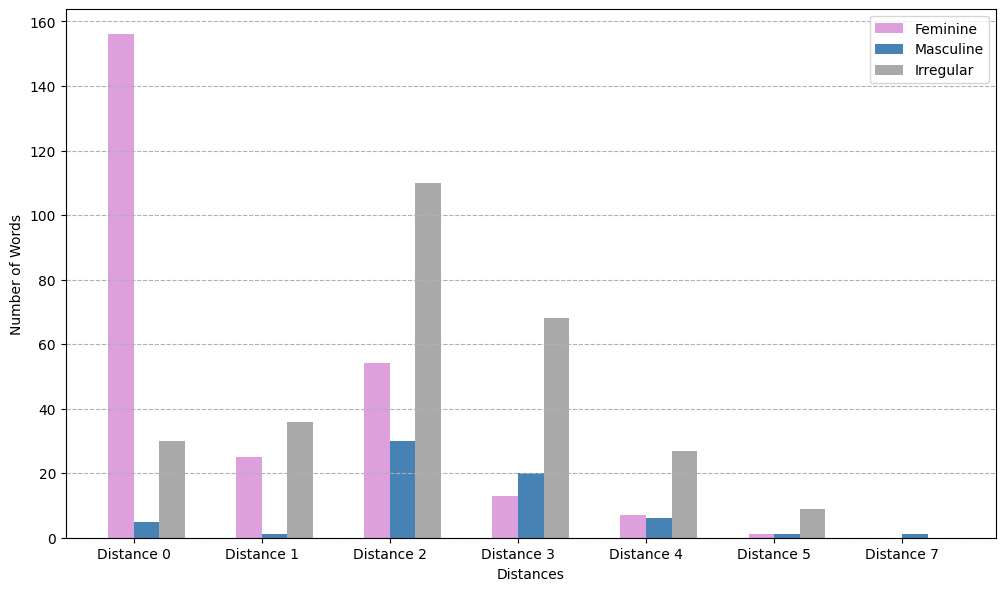

In [55]:
# plot a bar chart showing the distribution of the three classes in 
# distance value
plt.figure(figsize=(12, 7), dpi=100)
X = [f'Distance {i}' for i in range(8) if i != 6]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.1, feminine_counts_list, 0.2, label = 'Feminine', color='plum')
plt.bar(X_axis + 0.1, masculine_counts_list, 0.2, label = 'Masculine', color='steelblue')
plt.bar(X_axis + 0.3, takseer_counts_list, 0.2, label = 'Irregular', color='darkgray')

  
plt.xticks(X_axis, X)
plt.xlabel("Distances")
plt.ylabel("Number of Words")
# plt.title("Number of Words in Each Distance Range")
plt.legend()
plt.grid(linestyle='dashed', axis='y')
plt.savefig('number of words in each distance range.jpg', dpi=100, bbox_inches='tight')

# Model Progress 

In [56]:
# read the saved training progress dataset
df = pd.read_csv('https://drive.google.com/uc?export=download&id=16IkBKrjzTvzAS4hNCmkoRCm284GIwWEG')
cols = df.columns.tolist()
# rename the columns
cols = ['Train Loss', 'Train Accuracy', 'Train Top 5 Accuracy',
        'Valid Loss', 'Valid Accuracy', 'Valid Top 5 Accuracy']
df.columns = cols
df

,Train Loss,Train Accuracy,Train Top 5 Accuracy,Valid Loss,Valid Accuracy,Valid Top 5 Accuracy
0,129.729332,0.003550,0.095588,5.439922,0.036625,0.143230
1,124.469086,0.021552,0.132860,6.240949,0.061702,0.131164
2,119.895061,0.063387,0.174442,6.868495,0.064656,0.118113
3,118.806897,0.034990,0.110294,6.378825,0.106891,0.203718
4,105.124122,0.056288,0.159990,6.440104,0.074484,0.208504
...,...,...,...,...,...,...
95,0.989303,0.381592,0.391734,7.552056,0.266240,0.359112
96,0.978107,0.382099,0.391734,7.554486,0.266240,0.359112
97,0.967148,0.382099,0.391734,7.557542,0.266011,0.359112
98,0.956402,0.382099,0.391734,7.562794,0.265896,0.358997


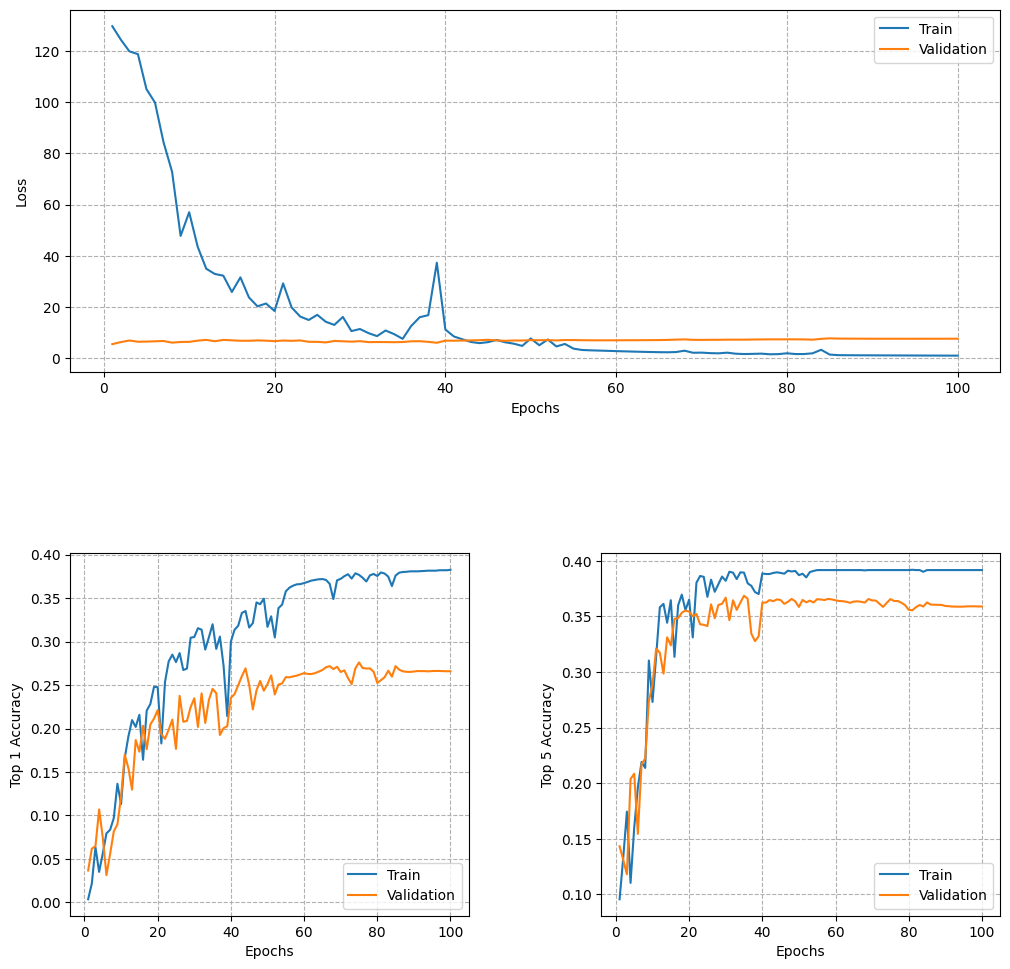

In [57]:
# plot loss vs epochs
plt.figure(figsize=(12, 12), dpi=100)
grid = plt.GridSpec(2, 4, wspace=1, hspace=0.5)
plt.subplot(grid[0, ::])
plt.plot(np.arange(1, 101), df['Train Loss'])
plt.plot(np.arange(1, 101), df['Valid Loss'])
plt.grid(linestyle='dashed')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(grid[1, :2])
# plot accuracy vs epochs
plt.plot(np.arange(1, 101), df['Train Accuracy'])
plt.plot(np.arange(1, 101), df['Valid Accuracy'])
plt.grid(linestyle='dashed')
plt.ylabel('Top 1 Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.subplot(grid[1, 2:])
# plot top 5 accuracy vs epochs
plt.plot(np.arange(1, 101), df['Train Top 5 Accuracy'])
plt.plot(np.arange(1, 101), df['Valid Top 5 Accuracy'])
plt.grid(linestyle='dashed')
plt.ylabel('Top 5 Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
# save figures
plt.savefig('metrics.jpg', dpi=100, bbox_inches='tight');